# TA-12 — Klasifikasi SMS Spam (Naive Bayes)

1) Load data + Encoding + Split 80/20
2) Train Multinomial Naive Bayes
3) Evaluasi (Confusion Matrix + Accuracy) + Analisis predict_proba
4) Simulasi prediksi data baru (2 dummy kontras)

Dataset: **SMS Spam Collection** (file `spam.csv` dengan kolom `v1` (ham/spam) dan `v2` (teks)).

> Catatan penting: Karena ini data teks, saya pakai **MultinomialNB**. **Feature scaling (StandardScaler) tidak diperlukan** dan biasanya wajibnya untuk **GaussianNB** pada data numerik.

## 0) Instalasi 
install ini:

```bash
pip install pandas scikit-learn
```

In [19]:
# 1) Import library
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score

## 1) Load dataset

In [11]:
# 2) Load data
# Pastikan file 'spam.csv' ada di folder yang sama dengan notebook ini.
data = pd.read_csv("spam.csv", encoding="latin-1")

# Ambil kolom penting saja: v1 (label) dan v2 (text)
data = data[['v1', 'v2']].copy()
data.columns = ['label', 'text']

data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 2) Encoding label (wajib)
encoding menjadi numerik. pakai **LabelEncoder**.

In [12]:
le = LabelEncoder()
data['label_encoded'] = le.fit_transform(data['label'])

label_mapping = {cls: int(idx) for idx, cls in enumerate(le.classes_)}
label_mapping

{'ham': 0, 'spam': 1}

## 3) Split data 80% training / 20% testing 

In [13]:
X_text = data['text']
y = data['label_encoded']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

len(X_train_text), len(X_test_text)

(4457, 1115)

## 4) Ekstraksi fitur teks → angka (CountVectorizer)
Teks diubah menjadi angka berdasarkan **frekuensi kata** (bag-of-words).

In [14]:
vectorizer = CountVectorizer()

# Fit hanya pada TRAIN untuk menghindari data leakage
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

X_train.shape, X_test.shape

((4457, 7701), (1115, 7701))

## 5) Train model Naive Bayes (MultinomialNB)

In [15]:
model = MultinomialNB()
model.fit(X_train, y_train)

print("Model berhasil dilatih.")

Model berhasil dilatih.


## 6) Evaluasi (Confusion Matrix + Accuracy)

In [16]:
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("Confusion Matrix (baris=actual, kolom=pred):")
print(cm)
print("\nAccuracy:", acc)

Confusion Matrix (baris=actual, kolom=pred):
[[961   5]
 [ 13 136]]

Accuracy: 0.9838565022421525


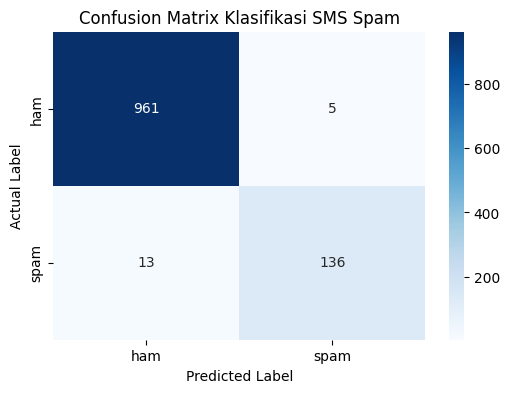

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Klasifikasi SMS Spam")
plt.show()


## 7) Analisis probabilitas (predict_proba)
Ambil 1 sampel test yang **salah prediksi** (jika ada). Jika tidak ada, ambil sampel acak.
Lalu tampilkan `predict_proba` dan lihat apakah model **yakin** atau **ragu-ragu**.

In [17]:
# Cari indeks yang salah prediksi
mis_idx = [i for i, (a, b) in enumerate(zip(y_test, y_pred)) if a != b]

if len(mis_idx) > 0:
    chosen_i = mis_idx[0]
    chosen_type = "Sampel SALAH prediksi (dari test set)"
else:
    chosen_i = random.randint(0, len(y_test) - 1)
    chosen_type = "Sampel ACAK (tidak ada yang salah prediksi)"

sample_text = X_test_text.iloc[chosen_i]
sample_true = int(y_test.iloc[chosen_i])
sample_pred = int(y_pred[chosen_i])

sample_vec = vectorizer.transform([sample_text])
proba = model.predict_proba(sample_vec)[0]  # [P(class0), P(class1)]

class0_label = le.inverse_transform([0])[0]
class1_label = le.inverse_transform([1])[0]

print("Jenis sampel:", chosen_type)
print("\nTeks sampel:\n", sample_text)
print("\nActual:", le.inverse_transform([sample_true])[0])
print("Pred  :", le.inverse_transform([sample_pred])[0])
print("\npredict_proba:")
print(f"P({class0_label}) = {proba[0]*100:.2f}%")
print(f"P({class1_label}) = {proba[1]*100:.2f}%")

print("\nInterpretasi cepat:")
if abs(proba[0]-proba[1]) < 0.1:
    print("- Model cenderung ragu-ragu (dekat 50%-50%).")
else:
    print("- Model cukup yakin (beda probabilitas besar).")

Jenis sampel: Sampel SALAH prediksi (dari test set)

Teks sampel:
 FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv

Actual: spam
Pred  : ham

predict_proba:
P(ham) = 99.95%
P(spam) = 0.05%

Interpretasi cepat:
- Model cukup yakin (beda probabilitas besar).


## 8) Simulasi prediksi data baru (2 dummy kontras)


- **Dummy A**: sangat 'spammy'
- **Dummy B**: chat normal

In [18]:
def predict_text(text):
    vec = vectorizer.transform([text])
    pred = int(model.predict(vec)[0])
    prob = model.predict_proba(vec)[0]
    return le.inverse_transform([pred])[0], prob

dummy_A = "CONGRATULATIONS! You WIN FREE cash prize, claim now, urgent, call now!"
dummy_B = "Hai, nanti pulang sekolah jadi makan bakso bareng ya?"

pred_A, prob_A = predict_text(dummy_A)
pred_B, prob_B = predict_text(dummy_B)

print("Dummy A:", dummy_A)
print("Prediksi:", pred_A)
print(f"Proba -> P({class0_label})={prob_A[0]*100:.2f}%, P({class1_label})={prob_A[1]*100:.2f}%")

print("\nDummy B:", dummy_B)
print("Prediksi:", pred_B)
print(f"Proba -> P({class0_label})={prob_B[0]*100:.2f}%, P({class1_label})={prob_B[1]*100:.2f}%")

Dummy A: CONGRATULATIONS! You WIN FREE cash prize, claim now, urgent, call now!
Prediksi: spam
Proba -> P(ham)=0.00%, P(spam)=100.00%

Dummy B: Hai, nanti pulang sekolah jadi makan bakso bareng ya?
Prediksi: ham
Proba -> P(ham)=99.69%, P(spam)=0.31%


## 9) Kesimpulan singkat 
- Kata-kata seperti **FREE**, **WIN**, **PRIZE**, **URGENT**, **CALL NOW** biasanya kuat mendorong prediksi ke **spam**.
- Kalimat percakapan normal cenderung mendorong prediksi ke **ham**.

